In [1]:
%cd /kaggle/input/chemcancer-v2/src/
%mkdir /kaggle/working/Deep_Learning_metrics/
%mkdir /kaggle/working/During_train/
%mkdir /kaggle/working/CV_CNN_models
%mkdir /kaggle/working/CV_CNN_results
%mkdir /kaggle/working/CV_CNN_fold_data
%mkdir /kaggle/working/CV_CNN_cm

/kaggle/input/chemcancer-v2/src


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.optimizers import Adam
from data import *
from machine_learning_models import *
from deep_learning_models import *
from vision_transformer import *
from utils_dl_model import *
from utils_ml_model import print_ml_results
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Set the seed value.
SEED = 7
np.random.seed(SEED)

# Deep Learning parameters
DL_EPOCH = 800
DL_BATCH_SIZE = 32
DL_CNN_VERSION = 3
DL_TRANSFORMER_VISION_VERSION = 14
DL_CV_FOLD = 5

DO_DL = True
CV_DL = True
OPT_DL = False

DO_CNN = True
DO_TRANSFORMER_VISION = False
DO_ML = False

# Percentage of test set out of the dataset.
TEST_SET = 0.2

# Percentage of validation set out of the training dataset.
VAL_SET = 0.2

# Folder path associated with deep learning models
dl_models_folder = "../Deep_Learning_models/"
dl_metrics_folder = "../Deep_Learning_metrics/"
dl_weights_folder = "../Deep_Learning_weights/"
dl_cv_models_folder = "../Deep_Learning_CV/"
dl_cv_results_folder = "../Deep_Learning_CV_results/"

# Folder path associated with machine learning models
ml_models_folder = "../Machine_Learning_models/"
ml_models_results_folder = "../Machine_Learning_models_results/"

# Model names (Saved in h5 format)
cnn_model_name = f"cnn_v{DL_CNN_VERSION}_{DL_BATCH_SIZE}_{DL_EPOCH}_seed_{SEED}.h5"
transformer_vis_model_name = f"transformer_vision_v{DL_TRANSFORMER_VISION_VERSION}_{DL_BATCH_SIZE}_{DL_EPOCH}_seed_{SEED}.h5"

# Metric filenames
cnn_metrics_filename = f"metrics_{cnn_model_name}.json"
transformer_vis_metrics_filename = f"metrics_{transformer_vis_model_name}.json"

# Weight filenames
cnn_weights_filename = f"weights_{cnn_model_name}.json"
transformer_vis_weights_filename = f"weights_{transformer_vis_model_name}.json"


# Deep Learning models path
if DO_CNN:
    dl_model_path = os.path.join(
        dl_models_folder, cnn_model_name)
elif DO_TRANSFORMER_VISION:
    dl_model_path = os.path.join(
        dl_models_folder, transformer_vis_model_name)


# Deep Learning metrics path
if DO_CNN:
    dl_metrics_path = os.path.join(
        dl_metrics_folder, cnn_metrics_filename)
elif DO_TRANSFORMER_VISION:
    dl_metrics_path = os.path.join(
        dl_metrics_folder, transformer_vis_metrics_filename)


# Deep Learning weights path
if DO_CNN:
    dl_weights_path = os.path.join(
        dl_weights_folder, cnn_weights_filename)

elif DO_TRANSFORMER_VISION:
    dl_weights_path = os.path.join(
        dl_weights_folder, transformer_vis_weights_filename)

In [4]:
def cnn_model_3(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate = 1e-4),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
       

    return model

In [5]:
# Apply median filter and background subtraction to the data
def apply_filters_and_background_subtraction(X):
    # Reshape the input data to a 2D array if necessary
    if len(X.shape) == 1:
        X = X.reshape((1, -1))
    
    # Apply median filter
    datamedfilt = scipy.ndimage.median_filter(X, size=(1, 5))
    
    # Apply airPLS for background subtraction
    baseline = np.zeros_like(datamedfilt)
    cols = baseline.shape[1]
    for col in range(cols):
        baseline[:, col] = airPLS(datamedfilt[:, col], lambda_=150)
    
    data_bksb = datamedfilt - baseline
    return datamedfilt

In [6]:
import pickle

def perform_cnn_cv(X, y, learning_rate, dropout_rate, l2_regularizer, 
                             n_splits=5, epochs=100, batch_size=32, cnn_version = 1, val_set = 0.2,
                             do_opt = False,apply_filters_bg_subtraction = True, models_folder = "models", results_folder = "results"):
    
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    # Initialize variables for tracking the best model
    best_val_accuracy = 0
    best_model_filepath = ""
    
    
    accuracies = []
    test_losses = []
    test_accuracies = []
    
    # Initialize lists to store precision, recall, and F1 scores
    precisions = []
    recalls = []
    f1_scores = []
    
    # Initialize lists to store losses and accuracies for each epoch
    mean_training_losses = []
    mean_training_accuracies = []
    mean_val_losses = []   
    mean_val_accuracies = []
    
    # Initialize lists to store losses and accuracies for each epoch
    all_training_losses = []
    all_training_accuracies = []
    all_val_losses = []   
    all_val_accuracies = []
    
    fold = 1
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)
    
    for train_index, test_index in skf.split(X, y):
        # Split the data into training and validation sets
        print("=" * 40)
        print(f"Fold: {fold}")
        print("Splitting the data")
        X_train_full, X_test = X[train_index], X[test_index]
        y_train_full, y_test = y[train_index], y[test_index]
        
        if apply_filters_bg_subtraction:
            print("Apply Filters")
            X_train_full =  apply_filters_and_background_subtraction(X_train_full)
            X_test =  apply_filters_and_background_subtraction(X_test)
        
        # Standardize the data
        print("Standardizing the data")
        X_train_full, X_test = standardize_data(X_train_full, X_test)
        
        # Reshape the data
        print("Reshaping the data for deep learning models")
        X_train_full, X_test = reshape_data(X_train_full, X_test)
        
        # Input shape and number of classes for the model
        input_shape = (X_train_full.shape[1], 1)
        num_classes = len(np.unique(y))
        
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state = seed_value, stratify = y_train_full)
        
        try:
            if do_opt:
                model = cnn_model_3(input_shape, num_classes)
#                 model = cnn_model_3_opt(input_shape, num_classes, learning_rate, dropout_rate, l2_regularizer)
            else:
                model = cnn_model_3(input_shape, num_classes)
            if model is not None:
                print("Building the model 3 with the following hyperparameters:")
                print(f"Learning rate: {learning_rate}")
                print(f"Dropout rate: {dropout_rate}") 
                print(f"L2 Regularizer: {l2_regularizer}")
                print(f"Number of epochs: {epochs}")
                print(f"Batch size: {batch_size}")
                # model.summary()
            else:
                print("Failed to build the CNN model.")
        except Exception as e:
            print(f"Error while building the CNN model: {e}")
        
        print("Saving the data")
        fold_data = {

            'X_train': X_train,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test
        }

        with open(f"/kaggle/working/CV_CNN_fold_data/fold_{fold}_data.pkl", 'wb') as f:
            pickle.dump(fold_data, f)
        
        filepath = f'/kaggle/working/CV_CNN_models/temp_best_fold_{fold}.h5'
        # the ModelCheckpoint callback to save the best model of the current fold
        model_checkpoint_callback = ModelCheckpoint(
            filepath=os.path.join(filepath),
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
        
        print("Training the model")
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                           callbacks=[model_checkpoint_callback])
        
         # Check if this model is the best so far
        max_val_accuracy_this_fold = max(history.history['val_accuracy'])
        if max_val_accuracy_this_fold > best_val_accuracy:
            best_val_accuracy = max_val_accuracy_this_fold
            best_model_filepath = filepath
            
        if best_model_filepath:
            best_model = tf.keras.models.load_model(
                best_model_filepath
            )
        print(f"The best model was loaded and ready to be evaluated")
        
        y_pred = np.argmax(model.predict(X_test), axis=-1)
        accuracy = accuracy_score(y_test, y_pred)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
            # Calculate precision, recall, and F1 score
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Append the scores to the lists
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        all_training_losses.extend(history.history['loss'])
        all_training_accuracies.extend(history.history['accuracy'])
        all_val_losses.extend(history.history['val_loss'])
        all_val_accuracies.extend(history.history['val_accuracy'])
        
        # Append the losses and accuracies for each epoch to the respective lists
        for epoch in range(epochs):
            if fold == 1:
                # For the first fold, initialize the lists with the first fold's values
                mean_training_losses.append(history.history['loss'][epoch])
                mean_training_accuracies.append(history.history['accuracy'][epoch])
                mean_val_losses.append(history.history['val_loss'][epoch])
                mean_val_accuracies.append(history.history['val_accuracy'][epoch])
            else:
                # For subsequent folds, add the fold's values to the running sum
                mean_training_losses[epoch] += history.history['loss'][epoch]
                mean_training_accuracies[epoch] += history.history['accuracy'][epoch]
                mean_val_losses[epoch] += history.history['val_loss'][epoch]
                mean_val_accuracies[epoch] += history.history['val_accuracy'][epoch]

        # Save the model
        if do_opt:
            model_filename = f"cnn_v{cnn_version}_opt_{batch_size}_{epochs}_seed{seed_value}.h5"
        else:
            model_filename = f"cnn_v{cnn_version}_{batch_size}_{epochs}_seed{seed_value}.h5"
        model_filepath = os.path.join(models_folder, f"fold_{fold}_split_{n_splits}_{model_filename}")
        model.save(model_filepath)

        # Save the results as a JSON file
        if do_opt:
            results_filename = f"cnn_v{cnn_version}_opt_{batch_size}_{epochs}_seed{seed_value}.json"
        else:
            results_filename = f"cnn_v{cnn_version}_{batch_size}_{epochs}_seed{seed_value}.json"
        results_filepath = os.path.join(results_folder, f"fold_{fold}_split_{n_splits}_{results_filename}")

        results = {
            "fold": fold,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_scores": f1_scores,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_loss": history.history['loss'],
            "training_accuracy": history.history['accuracy'],
            "validation_loss": history.history['val_loss'],
            "validation_accuracy": history.history['val_accuracy'],
        }

        with open(results_filepath, "w") as results_file:
            json.dump(results, results_file, indent=4)
        
        # Append the results to the lists
        accuracies.append(accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Fold {fold}, Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print("=" * 40)
        fold += 1

    # At the end, divide the sums by the number of folds to get the mean
    mean_training_losses = [loss / n_splits for loss in mean_training_losses]
    mean_training_accuracies = [acc / n_splits for acc in mean_training_accuracies]
    mean_val_losses = [loss / n_splits for loss in mean_val_losses]
    mean_val_accuracies = [acc / n_splits for acc in mean_val_accuracies]
    # Convert lists to numpy arrays for easier calculation of mean and standard deviation
    mean_accuracy = np.mean(accuracies)
    mean_test_loss = np.mean(test_losses)
    mean_test_accuracy = np.mean(test_accuracies)
    
    mean_training_loss = np.mean(all_training_losses)
    std_training_loss = np.std(all_training_losses)
    mean_training_accuracy = np.mean(all_training_accuracies)
    std_training_accuracy = np.std(all_training_accuracies)

    mean_val_loss = np.mean(all_val_losses)
    std_val_loss = np.std(all_val_losses)
    mean_val_accuracy = np.mean(all_val_accuracies)
    std_val_accuracy = np.std(all_val_accuracies)

    # Calculate standard deviations
    std_accuracy = np.std(accuracies)
    std_test_loss = np.std(test_losses)
    std_test_accuracy = np.std(test_accuracies)

    std_training_loss = np.std(mean_training_losses)
    std_training_accuracy = np.std(mean_training_accuracies)
    std_val_loss = np.std(mean_val_losses)
    std_val_accuracy = np.std(mean_val_accuracies)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1_scores = np.array(f1_scores)

      
    print(f"test losses: {test_losses}")
    print(f"test accuracy: {test_accuracies}")
    
    print("*" * 40)
    print(f"Mean training loss over {n_splits}-fold cross-validation: {mean_training_loss:.4f}")
    print(f"Mean training accuracy over {n_splits}-fold cross-validation: {mean_training_accuracy:.4f}")
    print(f"Mean validation loss over {n_splits}-fold cross-validation: {mean_val_loss:.4f}")
    print(f"Mean validation accuracy over {n_splits}-fold cross-validation: {mean_val_accuracy:.4f}")
    print("*" * 40)
    print(f"Mean accuracy over stratified {n_splits}-fold cross-validation: {mean_accuracy:.4f}")
    print(f"Mean test loss over stratified {n_splits}-fold cross-validation: {mean_test_loss:.4f}")
    print(f"Mean test accuracy over stratified {n_splits}-fold cross-validation: {mean_test_accuracy:.4f}")
    
    print("*" * 40)
    print(f"Standard deviation of training loss over {n_splits}-fold cross-validation: {std_training_loss:.4f}")
    print(f"Standard deviation of training accuracy over {n_splits}-fold cross-validation: {std_training_accuracy:.4f}")
    print(f"Standard deviation of validation loss over {n_splits}-fold cross-validation: {std_val_loss:.4f}")
    print(f"Standard deviation of validation accuracy over {n_splits}-fold cross-validation: {std_val_accuracy:.4f}")
        
    print("*" * 40)
    print(f"Standard deviation of accuracy over stratified {n_splits}-fold cross-validation: {std_accuracy:.4f}")
    print(f"Standard deviation of test loss over stratified {n_splits}-fold cross-validation: {std_test_loss:.4f}")
    print(f"Standard deviation of test accuracy over stratified {n_splits}-fold cross-validation: {std_test_accuracy:.4f}")
    print("*" * 40)
    
    # Calculate and print the mean and standard deviation of precision, recall, and F1 score
    print(f"Mean precision over stratified {n_splits}-fold cross-validation: {np.mean(precisions):.4f}")
    print(f"Standard deviation of precision over stratified {n_splits}-fold cross-validation: {np.std(precisions):.4f}")
    print(f"Mean recall over stratified {n_splits}-fold cross-validation: {np.mean(recalls):.4f}")
    print(f"Standard deviation of recall over stratified {n_splits}-fold cross-validation: {np.std(recalls):.4f}")
    print(f"Mean F1 score over stratified {n_splits}-fold cross-validation: {np.mean(f1_scores):.4f}")
    print(f"Standard deviation of F1 score over stratified {n_splits}-fold cross-validation: {np.std(f1_scores):.4f}")

    
# Define the directory where the JSON files are stored

    fig, axes = plt.subplots(2, n_splits, figsize=(20, 10))

    for fold in range(1, n_splits+1):
        # Load the JSON file for this fold
        if do_opt:
            cnn_filename = f"cnn_v{cnn_version}_opt_{batch_size}_{epochs}_seed{seed_value}.json"
        else:
            cnn_filename = f"cnn_v{cnn_version}_{batch_size}_{epochs}_seed{seed_value}.json"
        results_filename = f"fold_{fold}_split_{n_splits}_{cnn_filename}"
        
        results_filepath = os.path.join(results_folder, results_filename)
        
        with open(results_filepath, "r") as results_file:
            results = json.load(results_file)
        
        # Plot training and validation loss
        axes[0, fold-1].plot(results["training_loss"], label='Train')
        axes[0, fold-1].plot(results["validation_loss"], label='Validation')
        axes[0, fold-1].set_title(f'Fold {fold} Loss')
        axes[0, fold-1].set_xlabel('Epochs')
        axes[0, fold-1].set_ylabel('Loss')
        axes[0, fold-1].legend()

        # Plot training and validation accuracy
        axes[1, fold-1].plot(results["training_accuracy"], label='Train')
        axes[1, fold-1].plot(results["validation_accuracy"], label='Validation')
        axes[1, fold-1].set_title(f'Fold {fold} Accuracy')
        axes[1, fold-1].set_xlabel('Epochs')
        axes[1, fold-1].set_ylabel('Accuracy')
        axes[1, fold-1].legend()

    plt.tight_layout()
    plt.show()

    return mean_val_accuracies  

In [7]:
# Original data
data_file = "../Data/HC05_HC07.csv"

In [8]:
# Load the data
print("Load the data")
data = load_data(data_file)
print(f"Data shape : {data.shape}")

# Extract the feature and target data
print("Extract the feature and target data")
X, y = extract_data(data)
print(f"X shaped: {X.shape}")
print(f"y shaped: {y.shape}")

Load the data
Data shape : (2373, 274)
Extract the feature and target data
X shaped: (2373, 270)
y shaped: (2373,)


Fold: 1
Splitting the data
Apply Filters
Standardizing the data
Reshaping the data for deep learning models
Building the model 3 with the following hyperparameters:
Learning rate: 0.0001
Dropout rate: 0.4
L2 Regularizer: 0.0001
Number of epochs: 800
Batch size: 32
Saving the data
Training the model
Epoch 1/800
48/48 [==============================] - 13s 20ms/step - loss: 2.5610 - accuracy: 0.3472 - val_loss: 1.2855 - val_accuracy: 0.3184
Epoch 2/800
17/48 [=========>....................] - ETA: 0s - loss: 2.5962 - accuracy: 0.3235

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 7ms/step - loss: 2.5291 - accuracy: 0.3485 - val_loss: 1.3079 - val_accuracy: 0.3184
Epoch 3/800
48/48 [==============================] - 0s 8ms/step - loss: 2.3102 - accuracy: 0.3715 - val_loss: 1.3145 - val_accuracy: 0.3132
Epoch 4/800
48/48 [==============================] - 0s 10ms/step - loss: 2.0524 - accuracy: 0.3709 - val_loss: 1.3354 - val_accuracy: 0.3842
Epoch 5/800
48/48 [==============================] - 0s 8ms/step - loss: 1.9711 - accuracy: 0.3808 - val_loss: 1.4214 - val_accuracy: 0.3211
Epoch 6/800
48/48 [==============================] - 0s 9ms/step - loss: 2.0355 - accuracy: 0.3650 - val_loss: 1.3975 - val_accuracy: 0.3895
Epoch 7/800
48/48 [==============================] - 0s 8ms/step - loss: 1.8838 - accuracy: 0.3827 - val_loss: 1.3594 - val_accuracy: 0.3947
Epoch 8/800
48/48 [==============================] - 0s 8ms/step - loss: 1.8010 - accuracy: 0.4025 - val_loss: 1.3630 - val_accuracy: 0.4132
Epoch 9/800
48/48 [=====

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Standardizing the data
Reshaping the data for deep learning models
Building the model 3 with the following hyperparameters:
Learning rate: 0.0001
Dropout rate: 0.4
L2 Regularizer: 0.0001
Number of epochs: 800
Batch size: 32
Saving the data
Training the model
Epoch 1/800
48/48 [==============================] - 4s 13ms/step - loss: 2.5052 - accuracy: 0.3531 - val_loss: 1.3184 - val_accuracy: 0.3158
Epoch 2/800
15/48 [========>.....................] - ETA: 0s - loss: 2.3821 - accuracy: 0.3646

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 8ms/step - loss: 2.3240 - accuracy: 0.3544 - val_loss: 1.3476 - val_accuracy: 0.3211
Epoch 3/800
48/48 [==============================] - 0s 8ms/step - loss: 2.1085 - accuracy: 0.3874 - val_loss: 1.3241 - val_accuracy: 0.3237
Epoch 4/800
48/48 [==============================] - 0s 8ms/step - loss: 2.0845 - accuracy: 0.3650 - val_loss: 1.3143 - val_accuracy: 0.3368
Epoch 5/800
48/48 [==============================] - 0s 8ms/step - loss: 1.9598 - accuracy: 0.3762 - val_loss: 1.2693 - val_accuracy: 0.3395
Epoch 6/800
48/48 [==============================] - 0s 8ms/step - loss: 1.9485 - accuracy: 0.3762 - val_loss: 1.2385 - val_accuracy: 0.4632
Epoch 7/800
48/48 [==============================] - 0s 8ms/step - loss: 1.8216 - accuracy: 0.3887 - val_loss: 1.2088 - val_accuracy: 0.4974
Epoch 8/800
48/48 [==============================] - 0s 7ms/step - loss: 1.7130 - accuracy: 0.3880 - val_loss: 1.2045 - val_accuracy: 0.4474
Epoch 9/800
48/48 [======

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Standardizing the data
Reshaping the data for deep learning models
Building the model 3 with the following hyperparameters:
Learning rate: 0.0001
Dropout rate: 0.4
L2 Regularizer: 0.0001
Number of epochs: 800
Batch size: 32
Saving the data
Training the model
Epoch 1/800
48/48 [==============================] - 4s 13ms/step - loss: 2.6867 - accuracy: 0.3182 - val_loss: 1.2785 - val_accuracy: 0.3553
Epoch 2/800
19/48 [==========>...................] - ETA: 0s - loss: 2.4978 - accuracy: 0.3520

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 8ms/step - loss: 2.4681 - accuracy: 0.3439 - val_loss: 1.2792 - val_accuracy: 0.4105
Epoch 3/800
48/48 [==============================] - 0s 8ms/step - loss: 2.2176 - accuracy: 0.3669 - val_loss: 1.3144 - val_accuracy: 0.4263
Epoch 4/800
48/48 [==============================] - 0s 8ms/step - loss: 2.2222 - accuracy: 0.3603 - val_loss: 1.3023 - val_accuracy: 0.4474
Epoch 5/800
48/48 [==============================] - 0s 7ms/step - loss: 2.0964 - accuracy: 0.3610 - val_loss: 1.3347 - val_accuracy: 0.4237
Epoch 6/800
48/48 [==============================] - 0s 7ms/step - loss: 1.9373 - accuracy: 0.3874 - val_loss: 1.2951 - val_accuracy: 0.4289
Epoch 7/800
48/48 [==============================] - 0s 8ms/step - loss: 1.8836 - accuracy: 0.3933 - val_loss: 1.3451 - val_accuracy: 0.4211
Epoch 8/800
48/48 [==============================] - 0s 7ms/step - loss: 1.8055 - accuracy: 0.4104 - val_loss: 1.3451 - val_accuracy: 0.4132
Epoch 9/800
48/48 [======

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Standardizing the data
Reshaping the data for deep learning models
Building the model 3 with the following hyperparameters:
Learning rate: 0.0001
Dropout rate: 0.4
L2 Regularizer: 0.0001
Number of epochs: 800
Batch size: 32
Saving the data
Training the model
Epoch 1/800
48/48 [==============================] - 4s 19ms/step - loss: 2.4462 - accuracy: 0.3608 - val_loss: 1.2573 - val_accuracy: 0.4395
Epoch 2/800
17/48 [=========>....................] - ETA: 0s - loss: 2.3875 - accuracy: 0.3713

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 9ms/step - loss: 2.2446 - accuracy: 0.3759 - val_loss: 1.2470 - val_accuracy: 0.4816
Epoch 3/800
48/48 [==============================] - 0s 8ms/step - loss: 1.9487 - accuracy: 0.3950 - val_loss: 1.2637 - val_accuracy: 0.3868
Epoch 4/800
48/48 [==============================] - 0s 7ms/step - loss: 1.9467 - accuracy: 0.3673 - val_loss: 1.2874 - val_accuracy: 0.3868
Epoch 5/800
48/48 [==============================] - 0s 7ms/step - loss: 1.8404 - accuracy: 0.3733 - val_loss: 1.2939 - val_accuracy: 0.4237
Epoch 6/800
48/48 [==============================] - 0s 8ms/step - loss: 1.7987 - accuracy: 0.3970 - val_loss: 1.3038 - val_accuracy: 0.4737
Epoch 7/800
48/48 [==============================] - 0s 8ms/step - loss: 1.7371 - accuracy: 0.4200 - val_loss: 1.3072 - val_accuracy: 0.4789
Epoch 8/800
48/48 [==============================] - 0s 7ms/step - loss: 1.6568 - accuracy: 0.4042 - val_loss: 1.2908 - val_accuracy: 0.4684
Epoch 9/800
48/48 [======

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Standardizing the data
Reshaping the data for deep learning models
Building the model 3 with the following hyperparameters:
Learning rate: 0.0001
Dropout rate: 0.4
L2 Regularizer: 0.0001
Number of epochs: 800
Batch size: 32
Saving the data
Training the model
Epoch 1/800
48/48 [==============================] - 4s 13ms/step - loss: 3.0116 - accuracy: 0.3529 - val_loss: 1.3665 - val_accuracy: 0.2974
Epoch 2/800
19/48 [==========>...................] - ETA: 0s - loss: 2.6727 - accuracy: 0.3668

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 7ms/step - loss: 2.5995 - accuracy: 0.3647 - val_loss: 1.4967 - val_accuracy: 0.2974
Epoch 3/800
48/48 [==============================] - 0s 7ms/step - loss: 2.4369 - accuracy: 0.3700 - val_loss: 1.6233 - val_accuracy: 0.2974
Epoch 4/800
48/48 [==============================] - 0s 7ms/step - loss: 2.2896 - accuracy: 0.3542 - val_loss: 1.7002 - val_accuracy: 0.2974
Epoch 5/800
48/48 [==============================] - 0s 7ms/step - loss: 2.0899 - accuracy: 0.3891 - val_loss: 1.7893 - val_accuracy: 0.2974
Epoch 6/800
48/48 [==============================] - 0s 7ms/step - loss: 1.9827 - accuracy: 0.3746 - val_loss: 1.7442 - val_accuracy: 0.2974
Epoch 7/800
48/48 [==============================] - 0s 7ms/step - loss: 2.0109 - accuracy: 0.3957 - val_loss: 1.6764 - val_accuracy: 0.2974
Epoch 8/800
48/48 [==============================] - 0s 8ms/step - loss: 1.8024 - accuracy: 0.4062 - val_loss: 1.6376 - val_accuracy: 0.3053
Epoch 9/800
48/48 [======

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


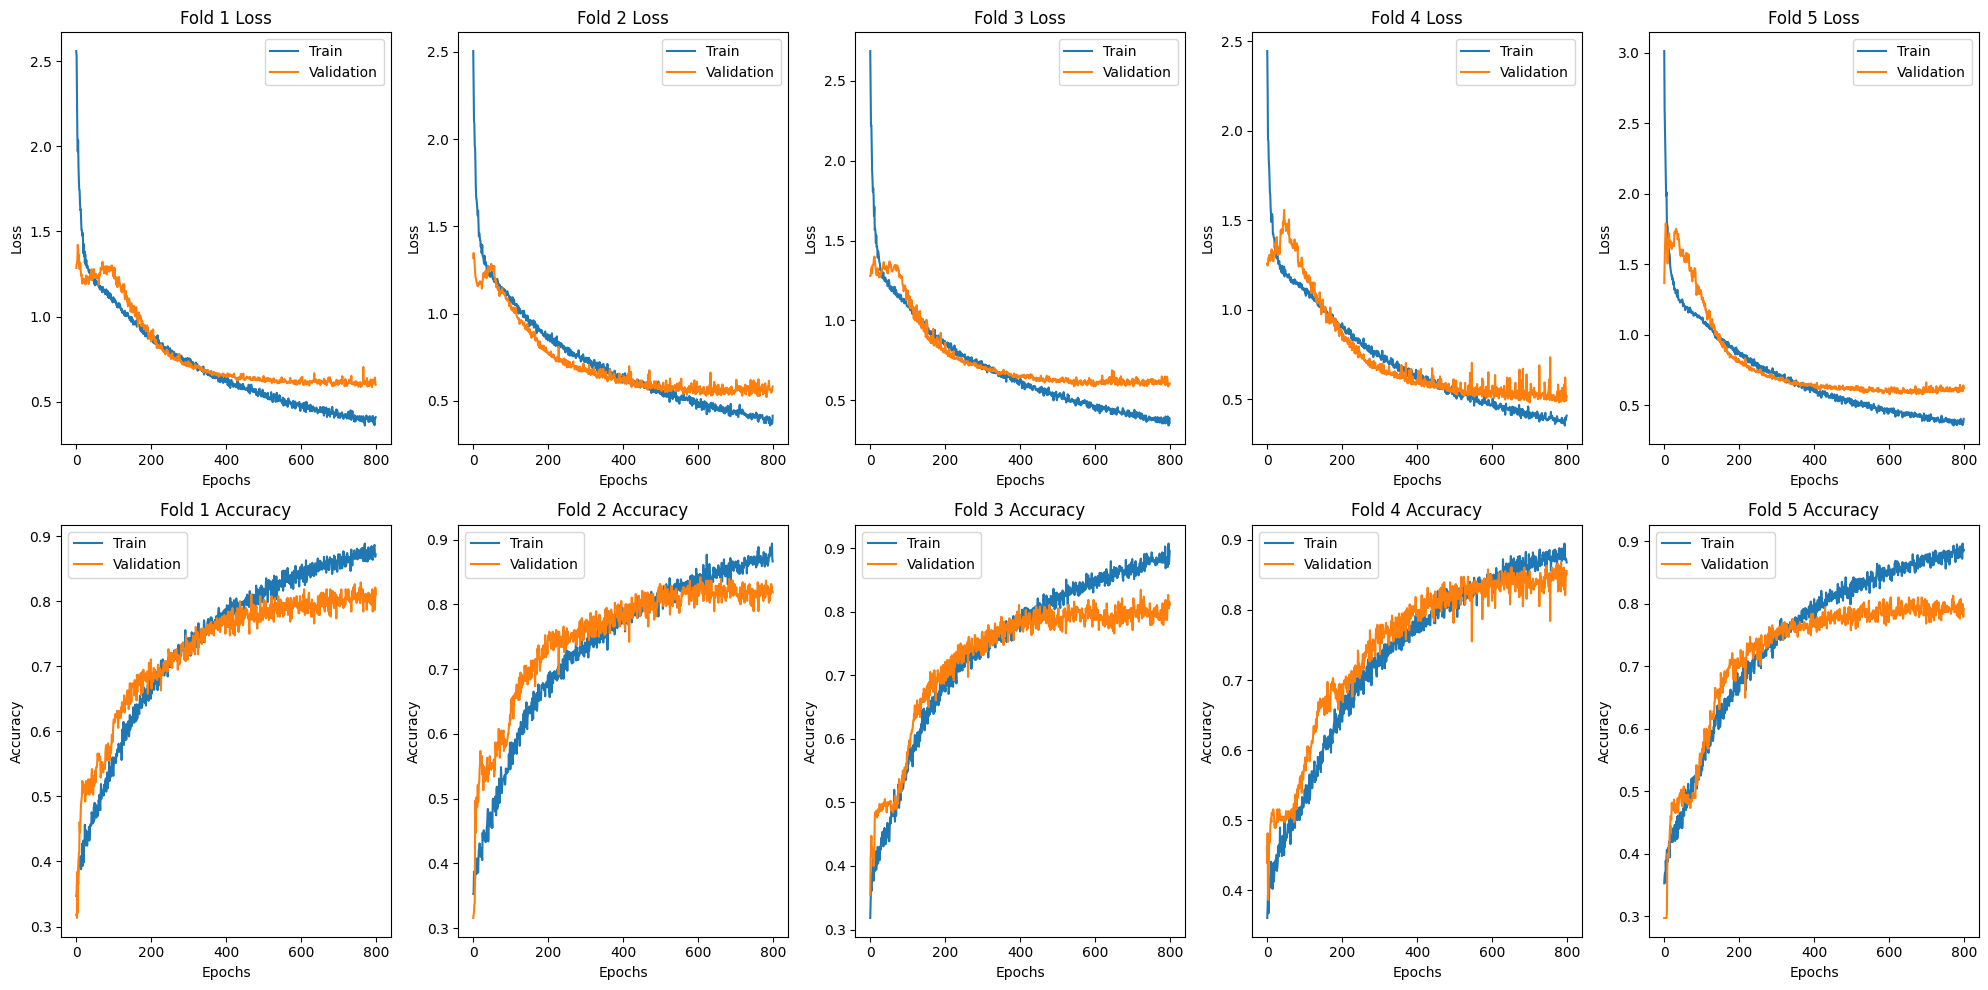

Training time: 1540.25 seconds


In [9]:

if CV_DL:
    if DO_CNN:
        learning_rate = 0.0001
        dropout_rate = 0.4
        l2_regularizer = 0.0001
        # Start the timer
        start_time = time.time()
        perform_cnn_cv(X, y, learning_rate, dropout_rate, l2_regularizer,
                                n_splits=DL_CV_FOLD, epochs=DL_EPOCH, batch_size=DL_BATCH_SIZE, cnn_version=DL_CNN_VERSION,
                                do_opt=True, apply_filters_bg_subtraction = True, models_folder="/kaggle/working/CV_CNN_models", results_folder= "/kaggle/working/CV_CNN_results")
        # End the timer
        end_time = time.time()
        # Calculate the elapsed time
        elapsed_time = end_time - start_time
        # Print the elapsed time
        print("Training time: {:.2f} seconds".format(elapsed_time))

In [10]:
# Given the paths you provided, let's generate confusion matrices for the VIT models:
cnn_model_path = "/kaggle/working/CV_CNN_models/"
data_model_path = "/kaggle/working/CV_CNN_fold_data/"
cm_model_path = "/kaggle/working/CV_CNN_cm/"

# Lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
confusion_matrices_cnn = []

# Loop through each fold
for fold in range(1, 6):
    # Load datasets for this fold
    with open(f"{data_model_path}fold_{fold}_data.pkl", 'rb') as f:
        fold_data = pickle.load(f)
        
    X_test = fold_data['X_test']
    y_test = fold_data['y_test']
    
    # Load the model for this fold
    model_file = f"fold_{fold}_split_5_cnn_v3_opt_32_800_seed7.h5"
    model_path = os.path.join(cnn_model_path, model_file)
    model = tf.keras.models.load_model(model_path)
    
    # Predict and evaluate
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    # Save the confusion matrix
    with open(f"{cm_model_path}cnn_cm_fold_{fold}.pkl", 'wb') as cm_file:
        pickle.dump(cm, cm_file)
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    confusion_matrices_cnn.append(cm)
    
    # Print metrics for this fold
    print(f"Fold {fold}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 40)

# This will give you a list of confusion matrices for each fold of the VIT models
confusion_matrices_cnn

15/15 [==============================] - 0s 2ms/step
Fold 1:
Accuracy: 0.8232
Precision: 0.8213
Recall: 0.8183
F1 Score: 0.8195
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 2:
Accuracy: 0.8021
Precision: 0.7981
Recall: 0.7980
F1 Score: 0.7980
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 3:
Accuracy: 0.7811
Precision: 0.7808
Recall: 0.7827
F1 Score: 0.7787
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 4:
Accuracy: 0.8080
Precision: 0.8019
Recall: 0.8026
F1 Score: 0.8021
----------------------------------------
15/15 [==============================] - 0s 2ms/step
Fold 5:
Accuracy: 0.8354
Precision: 0.8326
Recall: 0.8319
F1 Score: 0.8322
----------------------------------------


[array([[161,  12,  10],
        [ 14, 111,  17],
        [ 17,  14, 119]]),
 array([[156,  16,  11],
        [ 11, 111,  20],
        [ 17,  19, 114]]),
 array([[142,  23,  18],
        [  3, 121,  18],
        [ 17,  25, 108]]),
 array([[160,   9,  14],
        [  9, 110,  22],
        [ 10,  27, 113]]),
 array([[161,   6,  16],
        [  6, 116,  19],
        [ 15,  16, 119]])]